# Using our Enviroment

Before using our custom enviroment we must use pip to install it.

In [1]:
!pip install --user --upgrade --editable Assignment-1

Obtaining file:///X:/Reinforcement%20Learning/CS698R-ROMIT-MOHANTY-190720-ASSIGN-1/Assignment-1
  Attempting uninstall: Assignment-1
    Found existing installation: Assignment-1 1.0.0
    Uninstalling Assignment-1-1.0.0:
      Successfully uninstalled Assignment-1-1.0.0
  Running setup.py develop for Assignment-1


It's better to restart the kernel once the pip is done installing.

We now simply import gym, create our environment and run a few steps.

Set global seed for both random and numpy.random

We also set parameters required for making the environment

In [20]:
import gym
import numpy as np
import math
import random
from matplotlib import pyplot as plt
random.seed(3)
np.random.seed(3)
params={}

params["maxSteps"]=8000
params["goInDirection"]=0.5
params["gamma"]=1
params["noEpisodes"]=500
params["initial_value"]=1000000
params["final_value"]=400
noEpisodes=params["noEpisodes"]
gamma=params["gamma"]
maxSteps=params["maxSteps"]
env=gym.make('Assignment_1:RandomWalk-v0',params=params)
episodes = 10
for episode in range(1,episodes+1):
    state=env.reset()
    done= False
        # env.render()
    action =random.choice(list(range(0,env.action_space.n)))
        # action =0

    end_state, reward, done, info =env.step(action)
    
    print('Episode:{} End State: {} Reward:{} Action:{}'.format(episode,end_state,reward,action))

Episode:1 End State: 4 Reward:0 Action:0
Episode:2 End State: 4 Reward:0 Action:1
Episode:3 End State: 4 Reward:0 Action:0
Episode:4 End State: 4 Reward:0 Action:0
Episode:5 End State: 5 Reward:0 Action:1
Episode:6 End State: 4 Reward:0 Action:0
Episode:7 End State: 3 Reward:0 Action:1
Episode:8 End State: 6 Reward:1 Action:1
Episode:9 End State: 3 Reward:0 Action:0
Episode:10 End State: 1 Reward:0 Action:0


Taking Random Policy as the Environment is uniform i.e both transition probabilities are 0.5

In [3]:
policy=random.choices(([0,1]),k=maxSteps)

# Generate Trajectory Fucntion

In [21]:
def generateTrajectory(env, policy,maxSteps):
    
    list_exp_tuples=[]
    done=False
    for i in range (maxSteps):
        exp_tuples = np.zeros((4))
        exp_tuples[0]=env.currState()
        exp_tuples[1]=policy[i]
        end_state, reward, done, info=env.step(policy[i])
        exp_tuples[2]=end_state
        exp_tuples[3]=reward
        # print(done)
        list_exp_tuples.append(exp_tuples)
        if done==True:
            break
    if done==False:
        list_exp_tuples=[]
    return np.array(list_exp_tuples)
random.seed(3)
np.random.seed(3)
pi=np.ones(10)
r=generateTrajectory(env, pi,10)
print(r)

[[1. 1. 2. 0.]
 [2. 1. 3. 0.]
 [3. 1. 4. 0.]
 [4. 1. 5. 0.]
 [5. 1. 6. 1.]]


# Decay Alpha Function

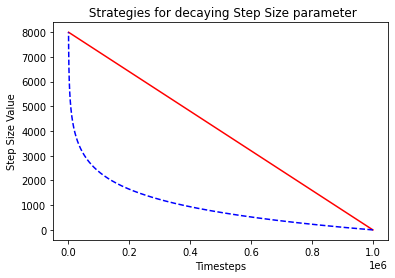

In [5]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType):
    step_size=np.zeros(maxSteps)
    if decayType=="Linear":
        decayRate=(initialValue-finalValue)/maxSteps
        for i in range(maxSteps):
            step_size[i]=initialValue-i*decayRate
        # plt.plot(np.arange(0,maxSteps),step_size, color='r')
        # plt.ylabel('Step_size Parameter w.r.t time')  
        # plt.xlabel('Timesteps') 
        # plt.title('Linear Decay of step size parameter') 
        # plt.savefig('Linear Decay of step size parameter.pdf') 
        # plt.close()
    if decayType=="Exp":
        decayRate=(np.log(initialValue/finalValue))/maxSteps
        step_size[0]=initialValue
        for i in range(maxSteps-1):
            step_size[i+1]=step_size[i]*np.exp(-decayRate)
        # plt.plot(np.arange(0,maxSteps),step_size, color='r')
        # plt.ylabel('Step_size Parameter w.r.t time')  
        # plt.xlabel('Timesteps') 
        # plt.title('Exponential Decay of step size parameter') 
        # plt.savefig('Exponential Decay of step size parameter.pdf') 
        # plt.close()
    return step_size
lin_x=decayAlpha(params["initial_value"],params["final_value"],params["maxSteps"],"Linear")
exp_x=decayAlpha(params["initial_value"],params["final_value"],params["maxSteps"],"Exp")
plt.plot(lin_x,np.arange(params["maxSteps"]),color='red',linestyle='-')
plt.plot(exp_x,np.arange(params["maxSteps"]),color='blue',linestyle='--')
plt.xlabel('Timesteps')
plt.ylabel('Step Size Value')
plt.title(' Strategies for decaying Step Size parameter')
plt.savefig('Decay Step Size.pdf')


Taking a list of steps using exponential decay

In [6]:
alpha=(decayAlpha(0.5,0.01,250,"Exp"))
for i in range(250):
    alpha = np.append(alpha,0.01)

# Monte Carlo Algo

In [7]:
def MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, firstVisit):
    v=np.zeros(env.observation_space.n)
    v_r=np.zeros((noEpisodes,env.observation_space.n))
    Gt=np.zeros(noEpisodes)
    for e in range(noEpisodes):
        env.reset()
        t=generateTrajectory(env, policy,maxSteps)
        # print(t[0][3])
        vis=np.zeros(env.observation_space.n)
        # print(t)
        for i in range(len(t)):
            s=t[i][0]
            # print(s)
            # print(len(vis))
            if vis[int(s)] and firstVisit:
                continue
            G=0
            # print(i,np.shape(t), np.size(t,axis=0))
            for j in range(i,len(t)):
                # print(np.shape(t))
                # print(j)
                G+=(pow(gamma,j-i)*t[j,3])
            if s==3:
                Gt[e]=G
            # print(e)
            v[int(s)]=v[int(s)]+alpha[int(e)]*(G-v[int(s)])
            vis[int(s)]=1
        
        v_r[e]=v
    return v, v_r,Gt

# Temporal Difference Learning Algo

In [8]:
def TemporalDifferencePrediction(env, policy, gamma , alpha, noEpisodes):
    v = np.zeros(env.observation_space.n)
    v_r = np.zeros((noEpisodes,env.observation_space.n))
    Gt=np.zeros(noEpisodes)
    for e in range(noEpisodes):
        s,done = env.reset()
        while not done:
            action=random.choices(([0,1]),k=1)
            next_state,reward,done,info = env.step(action)
            td_target = reward
            if not done:
                td_target = td_target + gamma*v[next_state]
            if s==3:
                Gt[e]=td_target
            td_error = td_target-v[s]

            v[s] = v[s] + alpha[e]*td_error
            s = next_state
        v_r[e] = v
    return v,v_r,Gt    

## Problem 5

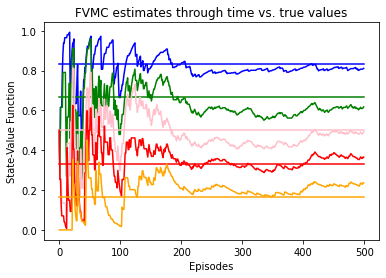

In [9]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, 1)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,5],color = 'blue')
plt.plot(x,5/6*o,color = 'blue',linestyle = "-")
plt.plot(x,v_r2[:,4],color = 'green')
plt.plot(x,4/6*o,color = 'green',linestyle = "-")
plt.plot(x,v_r2[:,3],color = 'pink')
plt.plot(x,3/6*o,color = 'pink',linestyle = "-")
plt.plot(x,v_r2[:,2],color = 'red')
plt.plot(x,2/6*o,color = 'red',linestyle = "-")
plt.plot(x,v_r2[:,1],color = 'orange')
plt.plot(x,1/6*o,color = 'orange',linestyle = "-")
plt.title("FVMC estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-5.pdf")

## Problem 6

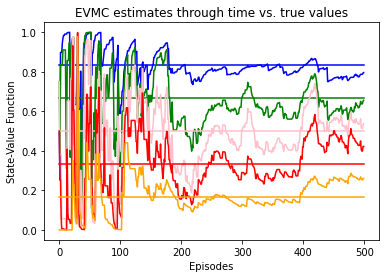

In [10]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, 0)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,5],color = 'blue')
plt.plot(x,5/6*o,color = 'blue',linestyle = "-")
plt.plot(x,v_r2[:,4],color = 'green')
plt.plot(x,4/6*o,color = 'green',linestyle = "-")
plt.plot(x,v_r2[:,3],color = 'pink')
plt.plot(x,3/6*o,color = 'pink',linestyle = "-")
plt.plot(x,v_r2[:,2],color = 'red')
plt.plot(x,2/6*o,color = 'red',linestyle = "-")
plt.plot(x,v_r2[:,1],color = 'orange')
plt.plot(x,1/6*o,color = 'orange',linestyle = "-")
plt.title("EVMC estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-6.pdf")

## Problem 7

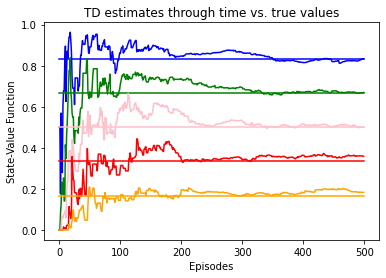

In [11]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt = TemporalDifferencePrediction(env, policy, gamma , alpha, noEpisodes)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,5],color = 'blue')
plt.plot(x,5/6*o,color = 'blue',linestyle = "-")
plt.plot(x,v_r2[:,4],color = 'green')
plt.plot(x,4/6*o,color = 'green',linestyle = "-")
plt.plot(x,v_r2[:,3],color = 'pink')
plt.plot(x,3/6*o,color = 'pink',linestyle = "-")
plt.plot(x,v_r2[:,2],color = 'red')
plt.plot(x,2/6*o,color = 'red',linestyle = "-")
plt.plot(x,v_r2[:,1],color = 'orange')
plt.plot(x,1/6*o,color = 'orange',linestyle = "-")
plt.title("TD estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-7.pdf")

##  Problem 8

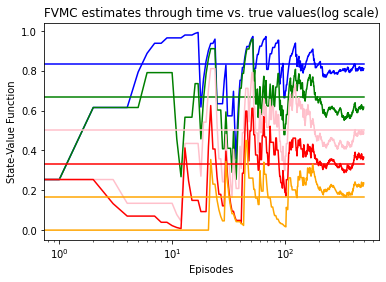

In [12]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, 1)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,5],color = 'blue')
plt.plot(x,5/6*o,color = 'blue',linestyle = "-")
plt.plot(x,v_r2[:,4],color = 'green')
plt.plot(x,4/6*o,color = 'green',linestyle = "-")
plt.plot(x,v_r2[:,3],color = 'pink')
plt.plot(x,3/6*o,color = 'pink',linestyle = "-")
plt.plot(x,v_r2[:,2],color = 'red')
plt.plot(x,2/6*o,color = 'red',linestyle = "-")
plt.plot(x,v_r2[:,1],color = 'orange')
plt.plot(x,1/6*o,color = 'orange',linestyle = "-")
plt.title("FVMC estimates through time vs. true values(log scale)")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-8.pdf")

## Problem 9

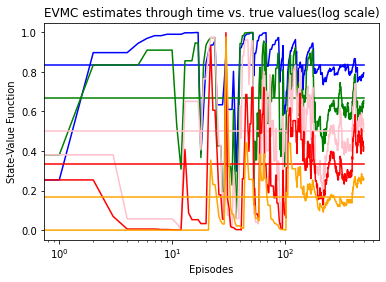

In [13]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, 0)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,5],color = 'blue')
plt.plot(x,5/6*o,color = 'blue',linestyle = "-")
plt.plot(x,v_r2[:,4],color = 'green')
plt.plot(x,4/6*o,color = 'green',linestyle = "-")
plt.plot(x,v_r2[:,3],color = 'pink')
plt.plot(x,3/6*o,color = 'pink',linestyle = "-")
plt.plot(x,v_r2[:,2],color = 'red')
plt.plot(x,2/6*o,color = 'red',linestyle = "-")
plt.plot(x,v_r2[:,1],color = 'orange')
plt.plot(x,1/6*o,color = 'orange',linestyle = "-")
plt.title("EVMC estimates through time vs. true values(log scale)")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-9.pdf")

## Problem 10

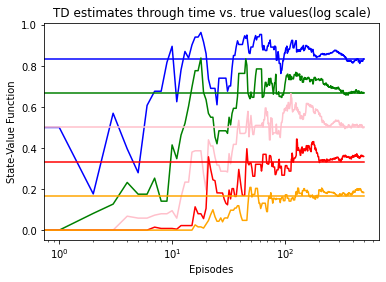

In [14]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt = TemporalDifferencePrediction(env, policy, gamma , alpha, noEpisodes)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,5],color = 'blue')
plt.plot(x,5/6*o,color = 'blue',linestyle = "-")
plt.plot(x,v_r2[:,4],color = 'green')
plt.plot(x,4/6*o,color = 'green',linestyle = "-")
plt.plot(x,v_r2[:,3],color = 'pink')
plt.plot(x,3/6*o,color = 'pink',linestyle = "-")
plt.plot(x,v_r2[:,2],color = 'red')
plt.plot(x,2/6*o,color = 'red',linestyle = "-")
plt.plot(x,v_r2[:,1],color = 'orange')
plt.plot(x,1/6*o,color = 'orange',linestyle = "-")
plt.title("TD estimates through time vs. true values(log scale)")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-10.pdf")

## Problem 12

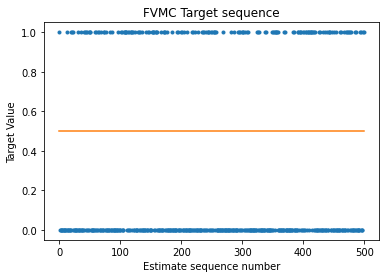

In [15]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, 1)
optVal=np.ones(noEpisodes)*3/6
x=np.arange(noEpisodes)
plt.plot(x,Gt,'.')
plt.plot(x,optVal)
plt.xlabel("Estimate sequence number")
plt.ylabel("Target Value")
plt.title("FVMC Target sequence")
plt.savefig("prob2 Q-12.pdf")

## Problem 13

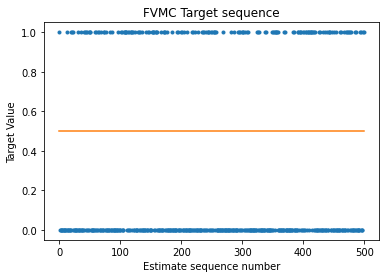

In [16]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, 0)
optVal=np.ones(noEpisodes)*3/6
x=np.arange(noEpisodes)
plt.plot(x,Gt,'.')
plt.plot(x,optVal)
plt.xlabel("Estimate sequence number")
plt.ylabel("Target Value")
plt.title("FVMC Target sequence")
plt.savefig("prob2 Q-13.pdf")

## Problem 14

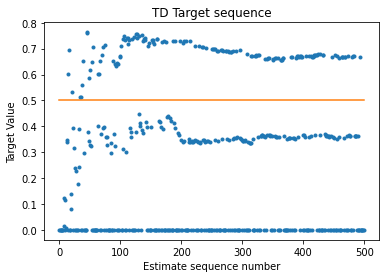

In [17]:
random.seed(3)
np.random.seed(3)
v,v_r2 ,Gt= TemporalDifferencePrediction(env, policy, gamma , alpha, noEpisodes)
optVal=np.ones(noEpisodes)*3/6
x=np.arange(noEpisodes)
plt.plot(x,Gt,'.')
plt.plot(x,optVal)
plt.xlabel("Estimate sequence number")
plt.ylabel("Target Value")
plt.title("TD Target sequence")
plt.savefig("prob2 Q-14.pdf")